In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import zipfile

%matplotlib inline

### Data Wrangling

In [2]:
# Opens zip file and creates data directory
# If files get large, will need to check to see if exists, and only replace new ones (or updates)
zip_ref = zipfile.ZipFile('./data.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [3]:
# read up the well data:
WellData_Raw = pd.read_csv("./data/welldata/WellData.csv",low_memory=False)

# get rid of the dup API nummber records by taking first in group
DimWell = WellData_Raw.groupby('API_num').first()

# ditch the wells for which there's no longitude or latitude:
DimWell.dropna(axis=0, how='any', subset=['long','lat'],inplace=True)

In [4]:
DimWell.name.isnull().sum(), len(DimWell)

(0, 73810)

In [5]:
def makeapinum(cnty, seq, sidetrack, st='05'):
    APInum = st + '-' + str(cnty).zfill(3) + '-' + str(seq).zfill(5) + '-' + \
                                            str(sidetrack).zfill(2)
    return APInum

In [6]:
# read up the production data
ProductionData_Raw = pd.read_csv("./data/welldata/Production.csv", low_memory=False)

# tack on an API code:
ProductionData_Raw['API_num'] = ProductionData_Raw.apply(lambda c:makeapinum(c.api_county_code, c.api_seq_num, c.sidetrack_num), axis=1)

# sum up the production data for each well:
FactProduction = ProductionData_Raw[['API_num','Prod_days','oil_prod']].groupby('API_num').sum()

# ditch the records for which there's no production data:
FactProduction.dropna(axis=0, how='any',inplace=True)

# join the Well data to the produciton data:
dimcols = ['long','lat', 'formation_code']
oil_df = FactProduction.merge(DimWell[dimcols], left_index=True, right_index=True)

In [7]:
len(DimWell), len(FactProduction), len(oil_df)

(73810, 53839, 53820)

In [8]:
oil_df.sort_values('oil_prod',ascending=False).head()[['oil_prod','lat','long']]

,oil_prod,lat,long
API_num,,,
05-123-41990-00,276767.0,40.423240,-104.355260
05-123-41991-00,270806.0,40.423344,-104.355260
05-123-43250-00,268426.0,40.440348,-104.924943
05-123-41987-00,229892.0,40.423550,-104.355250
05-123-41988-00,227726.0,40.423340,-104.355260


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1178ec208>]],
      dtype=object)

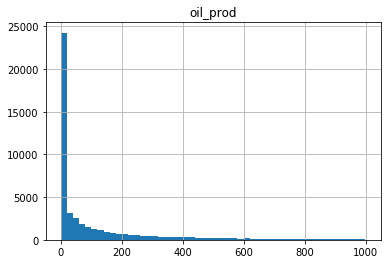

In [9]:
oil_df.query('oil_prod < 1000').hist('oil_prod',bins=50)

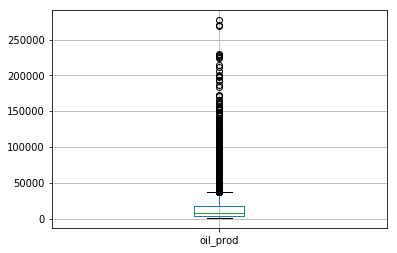

In [10]:
oil_df.query('oil_prod >= 1000').boxplot('oil_prod')

## Shapefiles

In [11]:
sf_path = "./data/shapefiles/US County/cb_2016_us_county_20m.shp"
us_county_sf = gpd.read_file(sf_path)

In [12]:
us_county_sf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,39,131,01074078,0500000US39131,39131,Pike,06,1140324458,9567612,"POLYGON ((-83.35353099999999 39.197585, -82.78..."
1,46,003,01266983,0500000US46003,46003,Aurora,06,1834813753,11201379,"POLYGON ((-98.807771 43.935223, -98.331508 43...."
2,55,035,01581077,0500000US55035,55035,Eau Claire,06,1652211310,18848512,"POLYGON ((-91.65045499999999 44.855951, -90.92..."
3,72,145,01804553,0500000US72145,72145,Vega Baja,13,118766803,57805868,"POLYGON ((-66.448989 18.387214, -66.4389500073..."
4,48,259,01383915,0500000US48259,48259,Kendall,06,1715747531,1496797,"POLYGON ((-98.920147 30.13829, -98.587897 30.1..."


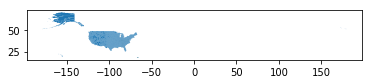

In [13]:
us_county_sf.plot()

### Clipping

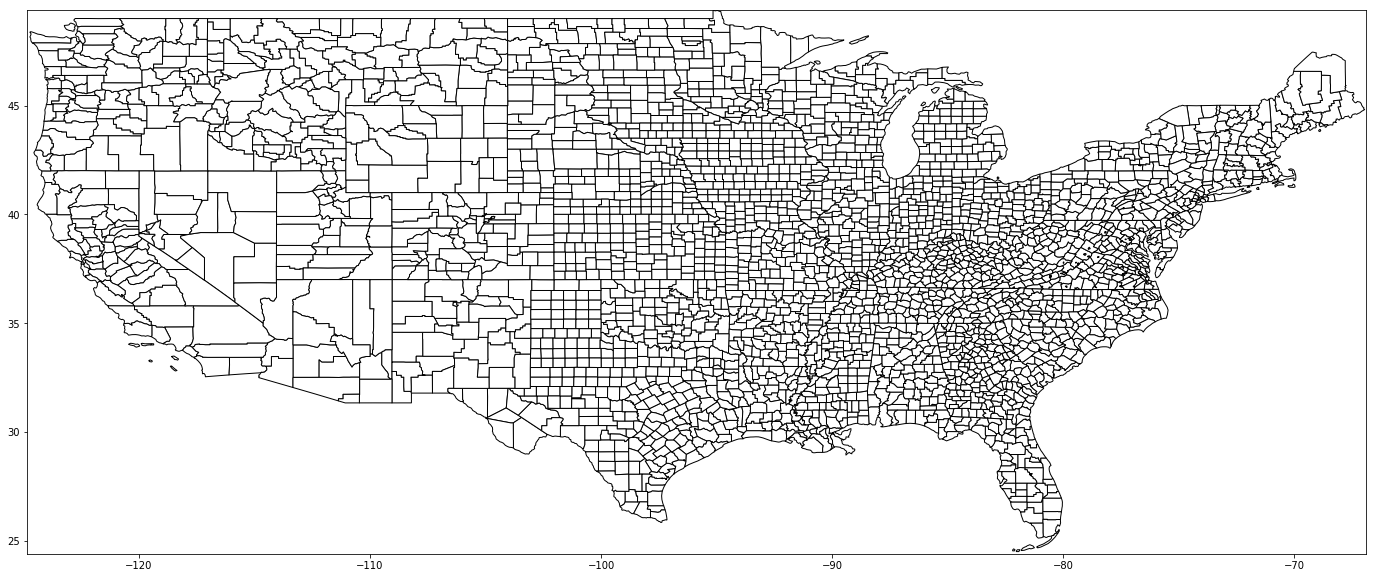

In [14]:
#from Google, coords for continental US:
x0,y0 = (-124.848974, 24.396308)
x1,y1 = (-66.885444, 49.384358)

fig, ax = plt.subplots(1,figsize=(24,10))
ax.set_xlim(x0,x1)
ax.set_ylim(y0,y1)
us_county_sf.plot(ax=ax,facecolor="white",edgecolor="black")


In [15]:
co_FIP = '08' # Colorado state FIPS code
co_county_sf=us_county_sf.query('STATEFP==@co_FIP')

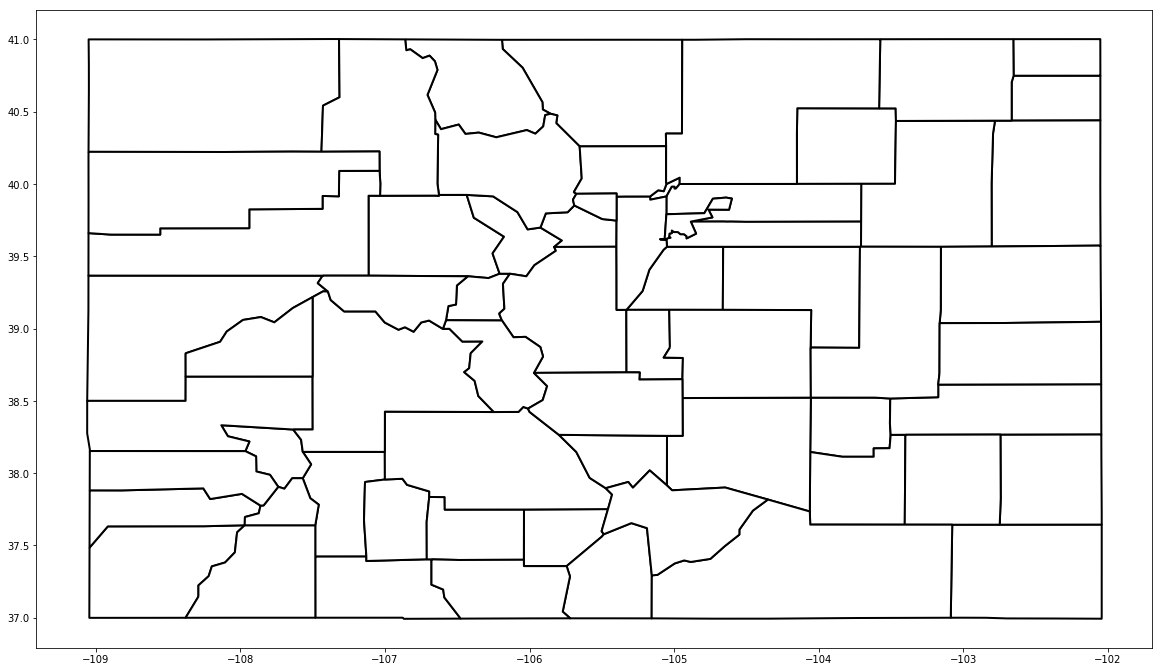

In [16]:
co_county_sf.plot(linewidth=2,facecolor="white",edgecolor="black",figsize=(20,14))

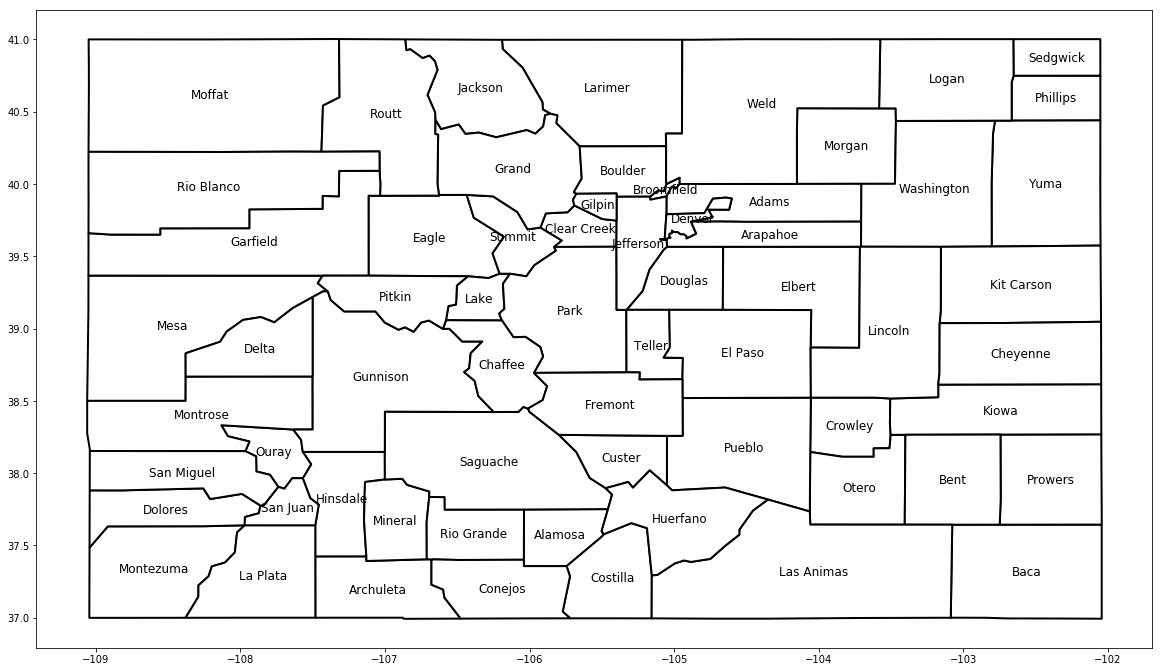

In [17]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')
co_county_sf.plot(ax=ax,linewidth=2,facecolor="white",edgecolor="black",figsize=(20,14))
for c in co_county_sf.itertuples():
    ax.annotate(c.NAME, xy=(c.geometry.centroid.x,c.geometry.centroid.y),
                                         va='center', ha='center', fontsize=12)

plt.show()    

In [18]:
def plot_co_county(ax, fc='None', ec='grey',lw=1, fs=12):
    co_county_sf.plot(ax=ax,linewidth=lw,facecolor=fc,edgecolor=ec,)
    for c in co_county_sf.itertuples():
        ax.annotate(c.NAME, xy=(c.geometry.centroid.x,c.geometry.centroid.y),
                                         va='center', ha='center', fontsize=fs, color=ec)

In [19]:
co_county_sf.total_bounds

array([-109.060062,   36.992426, -102.041876,   41.003073])

In [20]:
type(co_county_sf.geometry.iloc[0])

shapely.geometry.polygon.Polygon

### Cities in Colorado

In [21]:
city_sf_path = "./data/shapefiles/Colorado Cities/Colorado_City_Boundaries.shp"
co_cities = gpd.read_file(city_sf_path)


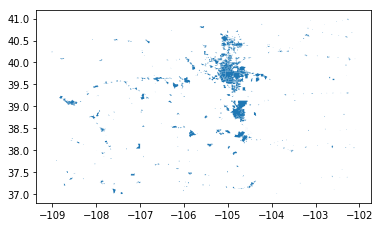

In [22]:
co_cities.plot()

In [23]:
co_cities.columns

Index(['OBJECTID', 'GEOID10', 'NAME10', 'NAMELSAD10', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [24]:
my_cities = ['Denver', 'Loveland', 'Fort Collins', 'Colorado Springs', 'Castle Rock' ,'Greeley', 'Boulder',
            'Grand Junction', 'Pueblo', 'Limon','Fort Morgan', 'Sterling', 'Lakewood', 'Aurora',
            'Fort Morgan', 'Trinidad', 'Glenwood Springs', 'Julesburg']

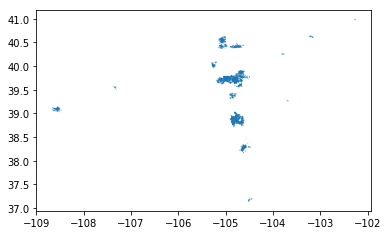

In [25]:
co_cities.query('NAME10 in @my_cities').plot()

In [26]:
def plot_co_cities(ax, fc='red', fs=10, subset=[]):
    
    if len(subset) == 0:
        cities = co_cities.copy()
    else: 
        cities = co_cities.query('NAME10 in @subset').copy()
    
    # where to put the labels
    cities['LabPoint'] = [(cty.geometry.bounds[2]+0.05,cty.geometry.bounds[3]) for cty in cities.itertuples()]
    
    # plot the cities
    cities.plot(ax=ax,facecolor=fc)
    
    # tack on the lables
    for c in cities.itertuples():
        ax.annotate(c.NAME10, xy=c.LabPoint,
                                         va='center', ha='left', fontsize=fs, color=fc)
    

## Plotting Arbitrary Points

In [27]:
from shapely.geometry import Point

In [28]:
from shapely.geometry import Point
crs = {'init': 'epsg:4269'}
pts = gpd.GeoSeries([Point(w.long, w.lat) for w in oil_df.itertuples()],crs=crs)

In [29]:
pts.head()

0      POINT (-103.74812 39.85915)
1       POINT (-103.7482 39.86821)
2      POINT (-103.74813 39.87002)
3    POINT (-103.811653 39.978286)
4    POINT (-103.818583 39.981528)
dtype: object

In [30]:
pts.crs

{'init': 'epsg:4269'}

Text(0.5,1,'Producing Oil Wells - Colorado 2017')

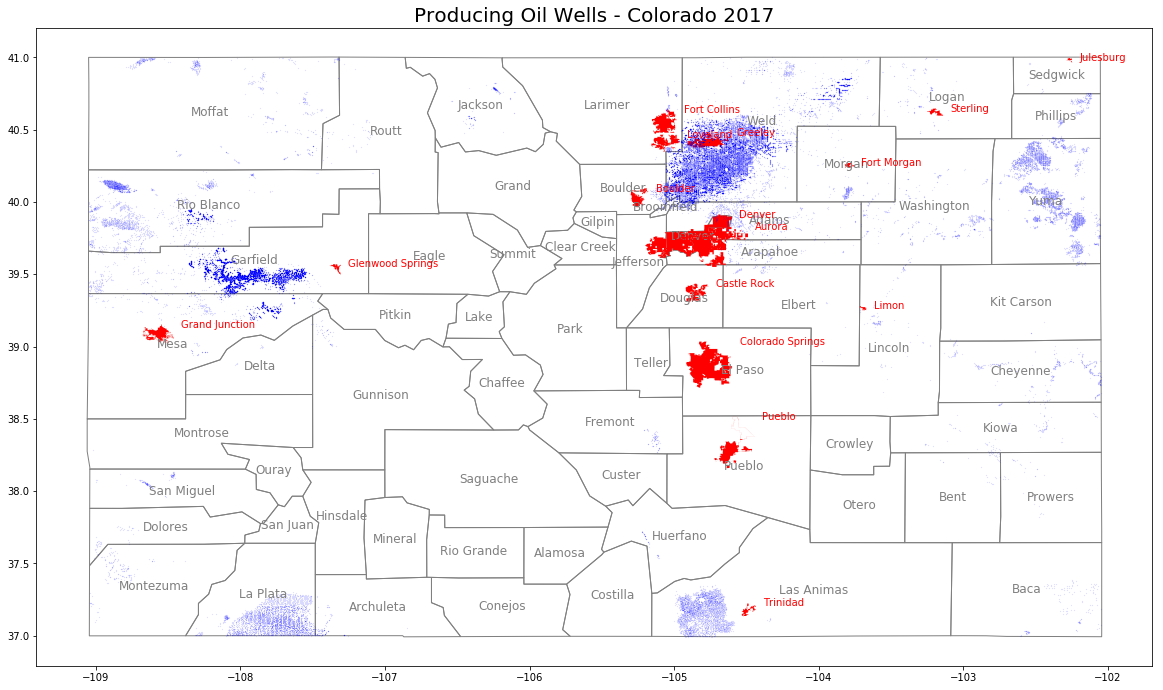

In [31]:

fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')


plot_co_county(ax=ax)

plot_co_cities(ax=ax, subset=my_cities)
pts.plot(ax=ax, marker='o', color='blue', markersize=0.025,alpha=0.3)

plt.title('Producing Oil Wells - Colorado 2017',size=20)

In [32]:
pts = [Point(ll) for ll in zip(oil_df.long, oil_df.lat)]

crs = {'init': 'epsg:4269'}
oil_gdf = gpd.GeoDataFrame(oil_df, crs=crs, geometry=pts)

In [33]:
# find the 5 most common formation codes
top5 = oil_gdf.groupby('formation_code').size().sort_values(ascending=False).iloc[0:5]
top5.index

Index(['CODL  ', 'NBRR  ', 'WFCM  ', 'N-COM ', 'WMFK  '], dtype='object', name='formation_code')

In [34]:
top5_formations = oil_gdf.query('formation_code in @top5.index')

In [37]:
#create groups by formation code
groups = top5_formations.groupby('formation_code')

#colors for each group
try:
    colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')
except Exception == 'AttributeError':
    colors = []

fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

# cylce through the colors for each group
ax.set_prop_cycle('color',colors)
for name, group in groups:
    group.plot(ax=ax, marker='o', markersize=1, label=name)

# county boundries
plot_co_county(ax=ax)

#city boundries
plot_co_cities(ax=ax,subset=my_cities,fs=12)

#legend
plt.legend(numpoints=1,fontsize=16,markerscale=10,title='Formation Code', facecolor="white",framealpha=1)

#title
plt.title("Colorado Oil Wells by Formation - 2017", size=20)

AttributeError: module 'pandas.tools.plotting' has no attribute '_get_standard_colors'

## Heatmap

Workflow:
1. Construct a grid over the study area
2. Map point data to grid cells
3. Aggregate (sum) point data within each cell
3. Plot the grid with cell values on a color scale

### Construct a Grid over the Study Area

#### Grid Parameters

In [ ]:
# Study area dimensions
bounds = co_county_sf.total_bounds.reshape(2,2)
x_min = bounds[0,0]; x_max = bounds[1,0]
y_min = bounds[0,1]; y_max = bounds[1,1]

#number of blocks in each direction
x_n = 10
y_n = 10

# longitudinal endpoints
x_vals, x_inc = np.linspace(x_min, x_max, x_n+1, retstep=True)

# Latitudinal endpoints
y_vals, y_inc = np.linspace(y_min, y_max, x_n+1, retstep=True)


#### Geopandas DataFrame for the Grid

In [ ]:
from shapely.geometry import LineString

#longitudinal gridlines
v_lines = [LineString([(x, y_min), (x, y_max)]) for x in x_vals]
# Latitudinal gridlines
h_lines = [LineString([(x_min, y), (x_max, y)]) for y in y_vals]

# centroids
block_centroids = []
#compute the centroids of each block in grid
#xx, yy = np.meshgrid(x_vals[0:x_n], y_vals[0:y_n])

#need x,y pairs
#xy = np.stack((np.matrix.flatten(xx), np.matrix.flatten(yy)), axis=1)

#offset by half the x_inc and y_inc values
#xy = xy + np.array([x_inc/2.0,y_inc/2.0]).reshape(1,2)

# convert to points
#block_centroids = [Point(xy[i,0],xy[i,1]) for i in range(xy.shape[0])]

# make a geopandas data frame out of it all
grid = gpd.GeoDataFrame(geometry=v_lines+h_lines+block_centroids)

#### Plot the Grid

In [ ]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')
oil_gdf.plot(ax=ax, marker='o', color='red', markersize=0.025,alpha=0.3)
# county boundries
plot_co_county(ax=ax)
grid.plot(ax=ax, linewidth=3)

### Map Point Data to Grid Cells

In [ ]:
from scipy.sparse import csr_matrix
oil_gdf.head()

In [ ]:
# map longitude and latitude to block columns and rows
oil_gdf['grid_col'] = np.floor((oil_gdf.long-x_min)/x_inc)
# Grid needs to flipped on lattitude axis (horizontal) because ndimage used below assumes origin in upper rigth corner
oil_gdf['grid_row'] = (y_n-1)-np.floor((oil_gdf.lat.values -y_min)/y_inc)

In [ ]:
oil_gdf.head()

### Compute Grid Cell Totals

In [ ]:
grid_totals = oil_gdf[['grid_row','grid_col','oil_prod']].groupby(['grid_row','grid_col']).sum()
grid_totals.reset_index(level=grid_totals.index.names, inplace=True)
grid_totals.query('oil_prod > 1000000')

#### Expland to Full (y_n, x_n) Matrix

In [ ]:
heatmap=csr_matrix((grid_totals.oil_prod, (grid_totals.grid_row, grid_totals.grid_col)), shape=( y_n,x_n)).toarray()

### Plot Cell Totals on Colorscale

In [ ]:
from scipy import ndimage
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

extent = [x_min, x_max, y_min, y_max]

smoothing=1.3
cmap='jet'

logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
plt.imshow(logheatmap, cmap=cmap,extent=extent, alpha=0.5)
plt.colorbar(shrink=0.6)
#plt.gca().invert_yaxis()

co_county_sf.plot(ax=ax, linewidth=2, facecolor='none', edgecolor='black')
#city boundries
plot_co_cities(ax=ax,subset=my_cities,fs=12)

plt.title('Heatmap of 2017 Oil Production - 10 x 10 Resolution, Log Scale', size=20)
plt.show()

### Heatmap Function

In [ ]:
def make_heatmap(d, bounds, bins=(10,10), log=True, Longitude = 'Longitude', Latitude = 'Latitude', val='Value', smoothing=1.3):
    
    #boundaries and number of x and y bins:
    xmin, ymin, xmax, ymax = bounds
    xbins, ybins = bins
    
    #cell width:
    xinc = (xmax - xmin)/xbins
    yinc = (ymax - ymin)/ybins
    
    #data frame columns we're interested in
    longi = d.columns.get_loc(Longitude)
    lati  = d.columns.get_loc(Latitude)
    vali  = d.columns.get_loc(val)
    
    #map the input longitude and Latitude into their corresponding column and row indices
    gridified = pd.DataFrame({'row_i':(ybins-1)-np.floor((d.iloc[:,lati]-ymin)/yinc), #y-axis needs to be flipped
                              'col_i': np.floor((d.iloc[:,longi]-xmin)/xinc),
                              'Value': d.iloc[:,vali]})
                              
    #get totals for each cell
    cell_totals = gridified.groupby(['row_i','col_i']).sum()
    cell_totals.reset_index(level=cell_totals.index.names, inplace=True)
    
    # expand out to a full matrix with shape (ybins, xbins)
    heatmap=csr_matrix((cell_totals.Value, (cell_totals.row_i, cell_totals.col_i)), shape=(ybins,xbins)).toarray()
    
    # compute log if desired
    if log:
        heatmap = np.log(heatmap)
        heatmap[np.isneginf(heatmap)] = 0
   
    # smooth over the values:    
    #heatmap = ndimage.filters.gaussian_filter(heatmap, smoothing, mode='nearest')
    
    return heatmap

### High(er) Resolution Heatmap

In [ ]:
bounds = co_county_sf.total_bounds
hm = make_heatmap(oil_gdf,bounds,bins=(1000,1000),Longitude='long',Latitude='lat',val='oil_prod')

In [ ]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

extent = [bounds[0], bounds[2], bounds[1], bounds[3]]

smoothing=1.3
cmap='YlOrRd'

# put up  the heatmap & color bar
plt.imshow(hm, cmap=cmap,extent=extent, alpha=0.5)
plt.colorbar(shrink=0.6)

# layer on the counties and cities
plot_co_county(ax=ax, fc='none', ec='lightgrey')
plot_co_cities(ax=ax,subset=my_cities,fc='blue',fs=12)

# jazzy title
plt.title('Heatmap of Colorado 2017 Oil Production and Key Cities',fontsize=18)

# show it
plt.show()

## Spatial Join

In [ ]:
NoCo_Cities = co_cities.query('NAME10 in [\'Fort Collins\', \'Loveland\', \'Greeley\']')


In [ ]:
Wells_in_NoCo_Cities = gpd.sjoin(oil_gdf, NoCo_Cities, how="inner", op='intersects')

In [ ]:
Wells_in_NoCo_Cities.head()

In [ ]:
x0,y0,x1,y1 = NoCo_Cities.total_bounds

fig, ax = plt.subplots(1,figsize=(24,10))
ax.set_xlim(x0,x1)
ax.set_ylim(y0,y1)

NoCo_Cities.plot(ax=ax,edgecolor='black', facecolor='lightgrey')
Wells_in_NoCo_Cities.plot(ax=ax, markersize=18, color='red')

# city labels:
for c in NoCo_Cities.itertuples():
    ax.annotate(c.NAME10, xy=(c.geometry.centroid.x,c.geometry.centroid.y),
                              va='center', ha='center', fontsize=18, color='black')
plt.title('Producing Oil Wells within Northern Colorado Cities',size=20)

In [ ]:
Wells_in_NoCo_Cities.query('NAME10 == \'Fort Collins\'')